In [1]:
import datetime as dt
from pathlib import Path
from typing import Union, Optional

import numpy as np
import pandas as pd

%matplotlib inline

## A few short snippets from the SOHO pipeline

#### We wrote several Fortran programs on VMS systems in the late 1990s and early 2000's to read raw SOHO data files and output text files suitable for printing or viewing on screen.  Since the files are meant for human reading there are descriptive headers and data columns separated by a varying number of spaces.  The headers have different lengths depending on which program created the file, so skiprows in pandas.read_csv would ahve to be adjusted for each file type read.  The line directly above the data begins with Year or YR with or without a leading space and contains column names.  This snippet skips over lines in the file until it encounters a line that starts with YR or Year.  The remainder of the file is read into a DataFrame using column names from the last line read.  The index is set to a DateTimeIndex using data in the first two columns.  The first line in the file contains the name of the program that created it, so the dataframe and first line are returned to the caller.

In [2]:
def read_data_file(filepath: Path, cols: Optional[list] = None) -> tuple[pd.DataFrame, str]:
    with open(filepath, 'r') as datafile:
        # read and discard lines until we reach a line strting with YR or YEAR
        file_length = filepath.stat().st_size
        line1 = datafile.readline() # contains Program Name
        while ('YR' not in (line := datafile.readline())[:6].upper() and
               'YEAR' not in line[:6].upper()):
            if datafile.tell() >= file_length:
                # reached EOF without finding YR or Year
                raise ValueError(f'{filepath} is not a valid SOHO data file')
        data = pd.read_csv(
            datafile,
            header=None,
            delim_whitespace=True,
            names=line.split(),
            usecols = cols,
            index_col=[0, 1])
    # YR indicates a 2 digit year in the first column, else a 4 digit year
    # the column after year contains times in the format DOY:HH:MM:SS
    year_fmt = 'y' if 'YR' in line[:6].upper() else 'Y'
    data.index = pd.to_datetime([f'{yr}:{jhms}' for yr, jhms in data.index.values],
                                format=f'%{year_fmt}:%j:%H:%M:%S')
    return data, line1

###
# pmsw.dat has a 2 digit year and 34 header lines before the column titles line
print(read_data_file(Path('data/pmsw.dat'))[0].iloc[:3, :6])
print()
# hk_stof.dat has a 4 digit year and 15 header lines before the column titles line
print(read_data_file(Path('data/hk_stof.dat'))[0].iloc[:3, :6])
print()
# badfile.dat does not have a line beginning with YR or Year
try:
    read_data_file(Path('data/badfile.dat'))
    print('read_data_file(badfile) should not have succeeded')
except ValueError:
    print('read_data_file expected failure')


                       Vsw   Dens    Vth  ANGLE  V_He   N/S
2022-01-01 01:41:54  464.3  2.791  33.23  -3.71   476  4.76
2022-01-01 01:57:03  457.8  1.935  34.47  -3.43   471  4.87
2022-01-01 02:12:08  475.3  1.867  40.98  -1.34   495  6.19

                     HVPS    LVPS    +5    +12    -5   -12
2022-10-07 00:01:12  0.00  241.18  5.01  12.07 -5.18 -12.0
2022-10-07 01:01:09  1.27  239.22  5.01  12.07 -5.18 -12.0
2022-10-07 02:01:06  1.27  241.18  5.01  12.07 -5.18 -12.0



ValueError: data/badfile.dat is not a valid SOHO data file

#### We sometimes need to join the data from our Fortran programs with other data.  Our data are taken at irregularly spaced times.  This join nearest neighbor routine does a "fuzzy" join on the index of our data by selecting rows from the other dataframe within ± **limit** of the index values.  If no suitable rows in the second dataframe are found nans are inserted

In [4]:
def joinnn(df1: pd.DataFrame, df2: pd.DataFrame, limit: dt.timedelta) -> pd.DataFrame:
    """
    Join two dataframes sorted by their DateTimeIndexes by the nearest neighbor within
    limit of the index values of the left dataframe.  If no suitable rows in the right
    dataframe exist insert nans. based on
    http://stackoverflow.com/questions/15127048/distribute-data-of-one-time-series-onto-another
    """
    midpts = df2.index.values[:-1] + 0.5 * (
        df2.index.values[1:] - df2.index.values[:-1]
    )
    # create a DataFrame using searchsorted to get a list of indices for df2's midpoints
    # in df1's indices
    ndx = midpts.searchsorted(df1.index.values, side='left')
    df3 = df2.copy().iloc[ndx]
    # set the df3 values outside of the time difference limit to NaN
    ndx = abs(df3.index.values - df1.index.values) > np.timedelta64(limit.seconds, 's')
    df3.iloc[ndx] = np.nan
    # set df3's index to df1's index so we can join them
    df3.index = df1.index
    return df1.join(df3)

###
# pmsw.dat has data roughly every 15 minutes.  orbitdata has data every 10 minutes
with pd.option_context('display.width', 1600):
    pmswdf, progname = read_data_file(Path('data/pmsw.dat'))
    orbitdf = pd.read_csv('data/orbitdata.csv', index_col=0, parse_dates=[0])
    print(joinnn(df1=pmswdf.loc[:, 'Vsw':'Vth'], 
                 df2=orbitdf.loc[:, 'GSE_X':'HGLAT'], 
                 limit=dt.timedelta(minutes=3.5))) # small limit is used here to have nans


                       Vsw   Dens    Vth       GSE_X      GSE_Y      GSE_Z       RANGE     HGLAT
2022-01-01 01:41:54  464.3  2.791  33.23  193.796909 -17.595837  14.891905  145.871826 -2.979381
2022-01-01 01:57:03  457.8  1.935  34.47  193.796873 -17.539243  14.893361  145.871802 -2.979381
2022-01-01 02:12:08  475.3  1.867  40.98  193.796853 -17.510943  14.894088  145.871790 -2.979381
2022-01-01 02:27:17  475.7  2.112  37.32  193.796812 -17.454336  14.895536  145.871767 -2.979381
2022-01-01 02:42:22  499.5  2.012  41.15  193.796789 -17.426030  14.896259  145.871755 -2.979381
2022-01-01 02:57:31  497.6  2.081  42.80  193.796742 -17.369410  14.897699  145.871732 -2.979381
2022-01-01 03:12:35  484.6  2.027  45.38  193.796718 -17.341097  14.898418  145.871720 -2.979381
2022-01-01 03:27:40  483.9  2.148  47.31  193.796665 -17.284464  14.899851  145.871697 -2.979381
2022-01-01 10:14:10  525.6  0.809  51.15         NaN        NaN        NaN         NaN       NaN
2022-01-01 10:29:15  520.7  0.

#### Line plots connect all non-nan points.  This can lead to a misleading plot if there are data gaps.  This routine will insert a row of nans between rows in a dataframe with a sorted DatetimeIndex that are more than gaptime apart

                       Vsw   Dens    Vth  ANGLE       GSE_X      GSE_Y      GSE_Z       RANGE     HGLAT
2022-01-01 03:27:40  483.9  2.148  47.31  -2.10  193.796665 -17.284464  14.899851  145.871697 -2.979381
2022-01-01 03:35:40    NaN    NaN    NaN    NaN         NaN        NaN        NaN         NaN       NaN
2022-01-01 10:14:10  525.6  0.809  51.15  -0.45  193.794852 -16.150091  14.927400  145.871264 -3.036676
2022-01-01 10:29:15  520.7  0.924  49.65  -0.72  193.794722 -16.093290  14.928722  145.871244 -3.036676
2022-01-01 10:44:24  532.8  0.846  52.46  -0.71  193.794656 -16.064886  14.929381  145.871234 -3.036676
2022-01-01 10:59:29  595.6  1.180  56.04  -3.62  193.794520 -16.008073  14.930696  145.871214 -3.036676
2022-01-01 11:14:38  602.6  1.303  54.04  -4.52  193.794451 -15.979664  14.931351  145.871204 -3.036676
2022-01-01 11:22:38    NaN    NaN    NaN    NaN         NaN        NaN        NaN         NaN       NaN
2022-01-01 19:45:47  535.7  1.844  57.50  -0.89  193.789489 -14.

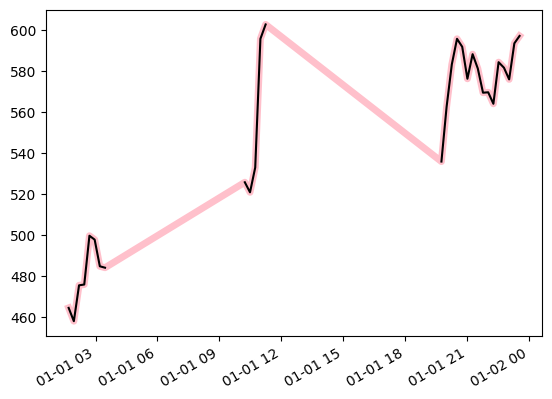

In [5]:
def nans_in_timegaps(
    df: pd.DataFrame, gaptime: Union[str, int, dt.timedelta, np.timedelta64]
) -> pd.DataFrame:
    """
    insert a row of nan's between rows in the dataFrame df that are separated
    in time by more than gaptime (a timedelta, timedelta64, or number of seconds).
    the dataframe must be sorted on its DatetimeIndex
    """
    if isinstance(gaptime, dt.timedelta):
        # convert a normal timedelta to a numpy.timedelta64
        gaptime = np.timedelta64(gaptime, 's')
    elif not isinstance(gaptime, np.timedelta64):
        # assume it's a number of seconds
        gaptime = np.timedelta64(int(gaptime), 's')
    else:
        # make sure timedelta64 is in seconds
        gaptime = gaptime.astype('<m8[s]')
    # gaps_ndx = df.index[1:].values - df.index[:-1].values > gaptime
    # nan_dates = df.iloc[:-1][gaps_ndx].index + gaptime / 2.
    # using argwhere is about 2x faster
    gaps_ndx = (np.argwhere(df.index[1:].values - df.index[:-1].values > gaptime)
                  .flatten()
                )
    if gaps_ndx.size == 0:
        return df
    nan_dates = df.index[gaps_ndx] + gaptime / 2.
    # concat df with an empty dataframe that has nan_dates as the index
    # to generate rows of nans in the gaps
    return (pd.concat([df, pd.DataFrame(index=nan_dates)])
              .sort_index()
            )

###
pmswdf, progline = read_data_file(Path('data/pmsw.dat'))
pmswdf = pmswdf.iloc[:-1]  # skip -2 flag row at the end of the data
orbitdf = pd.read_csv('data/orbitdata.csv', index_col=0, parse_dates=[0])
df = joinnn(pmswdf.loc[:, :'ANGLE'], 
            orbitdf.iloc[:, :5], 
            limit=dt.timedelta(minutes=5)
           )
df_for_plotting = nans_in_timegaps(df=df, gaptime=60 * 16)
with pd.option_context('display.width', 600):
    print(df_for_plotting.iloc[7:17])
ax = pmswdf['Vsw'].plot(c='pink', lw=5)  # appears to change linearly in gaps
df_for_plotting['Vsw'].plot(ax=ax, c='k');  # gaps are evident